# Read in Aggregate Recombination Files

In [1]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
aggregate_hgt_files = glob.glob('../6_parse_reconciliation/outputs/parsed_test_*_agg_regB.out')
gene_families = [re.search('parsed_test_(.*)_agg_regB.out',f).group(1) for f in aggregate_hgt_files]

In [3]:
gene_families

['ORF1ab',
 'ORF3a',
 'S',
 'ORF6',
 'E',
 'ORF7b',
 'ORF10',
 'N',
 'ORF8',
 'ORF7a',
 'M']

In [4]:
def read_transfer_file(fi):
    transfers = []
    start = False
    with open(fi,'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('all'):
                start = True
                continue
            if start:
                if '-' in line:
                    return transfers
                tr = line.strip().split()
                tr[2] = int(tr[2])
                transfers.append(tr)

def get_transfers(gf):
    gene_fam_path = f'../6_parse_reconciliation/outputs/parsed_test_{gf}_agg_regB.out'
    trans_ordered = read_transfer_file(gene_fam_path)
    trans_sorted = sorted(trans_ordered,key=lambda x: x[1],reverse=True)
    res = []
    for tr in trans_sorted:
        res.append([tr[0], tr[1], tr[2], gf])
    return res

def concat_df(df,df2):
    dfl = [df, df2]
    return pd.concat(dfl)

In [5]:
transfers_per_family = {gf: pd.DataFrame(get_transfers(gf)) for gf in gene_families}
transfers_raw = pd.concat(transfers_per_family.values()).sort_values(by=[2,3],ascending=False)[[0,1,3,2]]
transfers_raw.columns = ['Donor','Recipient','Gene Family','Support']

In [6]:
transfers_raw.head()

,Donor,Recipient,Gene Family,Support
14,KJ4738151,n44,S,1000
46,n15,MK2113751,S,1000
87,DQ0716151,DQ4120431,S,1000
103,GQ1535421,KJ4738151,ORF7a,1000
109,KF5699961,JX9939881,ORF7a,1000


# Merge with Name File

In [7]:
names = pd.read_csv('../supplements/TabS1_strain_names.csv')

We need to adjust the NCBI Accession numbers slightly to match with the accession numbers used in the aggregate recombination analysis.

In [8]:
namesPlus = [f"{i}1" for i in names['NCBI Accession']]
namesPlus[4] = 'NC0047183'
namesPlus[40] = 'DQ0223052'
namesPlus = pd.DataFrame(sorted(namesPlus),columns=['NCBI Extended'])

In [9]:
orig_names = names.set_index('NCBI Accession').sort_index().reset_index()[['NCBI Accession','Short ID']]
mapper = pd.concat([namesPlus,orig_names],axis=1)

In [10]:
mapper.head()

,NCBI Extended,NCBI Accession,Short ID
0,AY5720341,AY572034,C007
1,AY5720351,AY572035,C010
2,AY5720381,AY572038,C020
3,AY6868631,AY686863,A022
4,AY6868641,AY686864,B039


In [11]:
transfers = transfers_raw.replace(mapper['NCBI Extended'].values, mapper['Short ID'].values)

In [12]:
transfers

,Donor,Recipient,Gene Family,Support
14,GX2013,n44,S,1000
46,n15,YN2018A,S,1000
87,Rp3,Rm1,S,1000
103,HKU3_7,GX2013,ORF7a,1000
109,LYRa11,CpY11,ORF7a,1000
...,...,...,...,...
80,n9,YN2018A,ORF7b,1
56,n28,n34,E,1
87,Rs4247_147,n25,E,1
103,n25,n20,E,1


# Compute Support Thresholds

We compute support thresholds based on aggregate support values across unordered pairs of sequences. Thus, (A->B) with support 428 and (B->A) with support 221 has an aggregate support of 649.

In [13]:
def unorder_and_rename(p,mapper):
    newTrans = {}
    for (n0, n1, v) in p:
        if not n0.startswith('n'): #n0 is an ancestral node
            n0 = mapper[mapper['NCBI Extended'] == n0]['Short ID'].item()
        if not n1.startswith('n'): #n1 is an ancestral node
            n1 = mapper[mapper['NCBI Extended'] == n1]['Short ID'].item()
        if n0 < n1:
            k = (n0, n1)
        else:
            k = (n1, n0)
        s = newTrans.setdefault(k, 0)
        newTrans[k] = s + v
    return [(k,v) for k,v in newTrans.items()]

In [14]:
def get_transfers_unord(gene_fam,mapper):
    gene_fam_path = f"../6_parse_reconciliation/outputs/parsed_test_{gene_fam}_agg_regB.out"
    trans_unordered = unorder_and_rename(read_transfer_file(gene_fam_path),mapper)
    trans_sorted = sorted(trans_unordered,key=lambda x: x[1],reverse=True)
    res = []
    for tr in trans_sorted:
        res.append([tr[0][0], tr[0][1], tr[1], gene_fam])
    return res

In [15]:
unord_transfers_per_family = {gf: get_transfers_unord(gf,mapper) for gf in gene_families}

In [16]:
unordered = pd.concat([pd.DataFrame(unord_transfers_per_family[k]) for k in gene_families])
unordered = unordered.reset_index().drop(['index'],axis=1)
unordered.index = unordered[0]+'+'+unordered[1]
unordered.columns = ['First','Second','Support','Gene Family']

In [17]:
unordered

,First,Second,Support,Gene Family
n2+n35,n2,n35,1000,ORF1ab
Rs4231+n21,Rs4231,n21,1000,ORF1ab
HeB2013+Jiyuan_84,HeB2013,Jiyuan_84,1000,ORF1ab
Rs4081+WIV16,Rs4081,WIV16,1000,ORF1ab
HuB2013+Rm1,HuB2013,Rm1,1000,ORF1ab
...,...,...,...,...
C020+n14,C020,n14,4,M
n2+n33,n2,n33,4,M
SARS-CoV+n33,SARS-CoV,n33,4,M
C007+n2,C007,n2,4,M


In [18]:
unordered_pivot = unordered.pivot(None, 'Gene Family','Support').fillna(0)
# Re-order genes to be in correct viral order
unordered_pivot = unordered_pivot[['ORF1ab','S','ORF3a','E','M','ORF6','ORF7a','ORF7b','ORF8','N','ORF10']]
unordered_pivot['Total'] = unordered_pivot.sum(axis=1)
unordered_pivot = unordered_pivot.sort_values(by='Total',ascending=False)
support_values = unordered_pivot.iloc[:,:-1].values.ravel()

In [19]:
# Write for later analysis
unordered_pivot.to_csv('unordered_pivot.csv')

In [20]:
pcnt95 = np.quantile(support_values, 0.95)
pcnt99 = np.quantile(support_values, 0.99)
pcnt995 = np.quantile(support_values, 0.995)

print(f"# 95th Percentile: {pcnt95}")
print(f"# 99th Percentile: {pcnt99}")
print(f"# 99.5th Percentile: {pcnt995}")

# 95th Percentile: 100.0
# 99th Percentile: 500.0
# 99.5th Percentile: 808.6000000000058


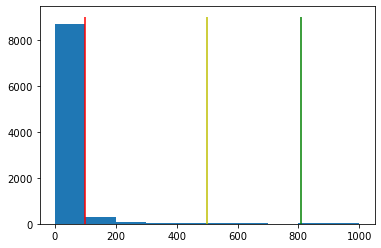

In [21]:
plt.hist(support_values)
plt.vlines([pcnt95, pcnt99, pcnt995],0,9000,colors=['r','y','g'])
plt.show()

# Save All Transfers above 95th Percentile

In [22]:
supported_transfers = transfers[transfers['Support'] >= pcnt95]

In [23]:
supported_transfers

,Donor,Recipient,Gene Family,Support
14,GX2013,n44,S,1000
46,n15,YN2018A,S,1000
87,Rp3,Rm1,S,1000
103,HKU3_7,GX2013,ORF7a,1000
109,LYRa11,CpY11,ORF7a,1000
...,...,...,...,...
181,YN2018C,Rs4081,E,100
231,n44,RpS11,E,100
232,n15,Rs672,E,100
246,Rs4084,Rp3,E,100


In [24]:
transfers.to_csv('unclipped_transfer_table.csv',header=True,index=None)
supported_transfers.to_csv('clean_transfer_table.csv',header=True,index=None)